Import relevant packages



In [ ]:
import re
import json
import random
import collections

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, svm
from sklearn.feature_extraction.text import TfidfTransformer

import tweepy

%matplotlib inline  

0.3027054330424338


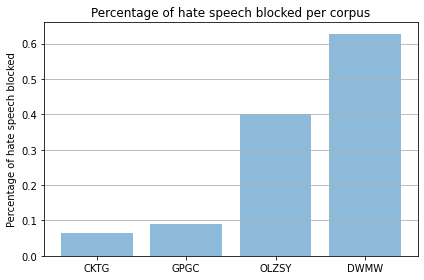

In [ ]:
### Plot accuracy of blocklists found below
hatespeechblocked = [0.06456126324205477, 0.08946488294314381, 0.40003541703559414, 0.6286713286713287]
labels = ["CKTG", "GPGC", "OLZSY", "DWMW"]

#plt.bar(labels, hatespeechblocked)
fig, ax = plt.subplots()
ax.bar(labels, hatespeechblocked, alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("Percentage of hate speech blocked")
ax.yaxis.grid(True)
ax.set_title("Percentage of hate speech blocked per corpus")
plt.tight_layout()
plt.savefig("percentageblocked")

print(np.mean([0.08946488294314381, 0.09265010351966874, 0.40003541703559414, 0.6286713286713287]))

Load blocklist

In [ ]:
### Load and split blocklists
with open('blocklist.txt') as b:
  blocklist = list(map(lambda x: x.strip(), b.readlines()))
print(blocklist)

with open('blocklistfr.txt') as b:
  blocklistfr = list(map(lambda x: x.strip(), b.readlines()))
print(blocklistfr)

#with open('commonwords.txt') as b:
#  commonlist = list(map(lambda x: x.strip(), b.readlines()))
#print(commonlist)

['2g1c', '2 girls 1 cup', 'acrotomophilia', 'alabama hot pocket', 'alaskan pipeline', 'anal', 'anilingus', 'anus', 'apeshit', 'arsehole', 'ass', 'asshole', 'assmunch', 'auto erotic', 'autoerotic', 'babeland', 'baby batter', 'baby juice', 'ball gag', 'ball gravy', 'ball kicking', 'ball licking', 'ball sack', 'ball sucking', 'bangbros', 'bangbus', 'bareback', 'barely legal', 'barenaked', 'bastard', 'bastardo', 'bastinado', 'bbw', 'bdsm', 'beaner', 'beaners', 'beaver cleaver', 'beaver lips', 'beastiality', 'bestiality', 'big black', 'big breasts', 'big knockers', 'big tits', 'bimbos', 'birdlock', 'bitch', 'bitches', 'black cock', 'blonde action', 'blonde on blonde action', 'blowjob', 'blow job', 'blow your load', 'blue waffle', 'blumpkin', 'bollocks', 'bondage', 'boner', 'boob', 'boobs', 'booty call', 'brown showers', 'brunette action', 'bukkake', 'bulldyke', 'bullet vibe', 'bullshit', 'bung hole', 'bunghole', 'busty', 'butt', 'buttcheeks', 'butthole', 'camel toe', 'camgirl', 'camslut', '

In [ ]:
# Check if a blocked term occurs in a tweet for datasets other than Davidson (2017)
def blocked_term_in_tweet2(blocklist, tweet):
  sentence = tweet.split()
  for blocked in blocklist:
    blocked_split = blocked.split()
    for j in range(len(sentence)):
      if sentence[j].lower() == blocked_split[0].lower():
        blocked_found = True
        for i in range(len(blocked_split)):
          if j+i >= len(sentence) or sentence[j+i].lower() != blocked_split[i].lower():
            blocked_found = False
        if blocked_found == True:
          return True
  return False

In [ ]:
### Sanity check for above function
def test(blocklist, tweet):
  sentence = tweet.split()
  for blocked in blocklist:
    blocked_split = blocked.split()
    for j in range(len(sentence)):
      if sentence[j].lower() == blocked_split[0].lower():
        blocked_found = True
        for i in range(len(blocked_split)):
          if j+i >= len(sentence) or sentence[j+i] != blocked_split[i]:
            blocked_found = False
        if blocked_found:
          return blocked
  return ""

In [ ]:
### Load in CONAN dataset, classify documents and counter-narratives based on blocklists
df4 = pd.read_csv("Multitarget-CONAN.csv")
df4["blocked_term_in_speech"] = [blocked_term_in_tweet2(blocklist, tweet) for tweet in df4["HATE_SPEECH"]]
df4["blocked_term_in_counterspeech"] = [blocked_term_in_tweet2(blocklist, tweet) for tweet in df4["COUNTER_NARRATIVE"]]
df4.head(15)

,INDEX,HATE_SPEECH,COUNTER_NARRATIVE,TARGET,VERSION,blocked_term_in_speech,blocked_term_in_counterspeech
0,0,Maybe the UN could talk to those asian and afr...,"You're right, ocean pollution is one of the ma...",other,V1,True,False
1,1,‘Juice (Jews) are worse that nukes.’ Caption t...,You'd rather be nuked then?,JEWS,V1,False,False
2,2,Foreigners on UK benefits leaps 41% in 5 years...,You seem to be worried about government expend...,MIGRANTS,V1,False,False
3,3,"Jews cannot be patriots, since their allegianc...",You can have parents and grandparents born els...,JEWS,V1,False,False
4,4,"Israel, Zionism and Jewish Supremacist control...",Wouldn't you say its colonialism from many dif...,JEWS,V1,False,False
5,5,"Women are basically childlike, they remain thi...",Would you say the same thing to the women who ...,WOMEN,V1,False,False
6,6,Foreigners on UK benefits leaps 41% in 5 years...,"Would be intersting to see how much money ""for...",MIGRANTS,V1,False,False
7,7,"Race is a social construct, and if you see any...","Women are women the world over, full stop.",POC,V1,False,False
8,8,Who the fuck are you? We are gutful sick of Va...,Without women there would be no men.,WOMEN,V1,True,False
9,9,"Women are basically childlike, they remain thi...",WIthout softeness and emotions there would jus...,WOMEN,V1,False,False


In [ ]:
### Determine percentage of documents and counternarratives blocked
### This dataset contains only hate speech so we can do this on the full dataset
blocked4 = df4[df4["blocked_term_in_speech"] == True]
blockedalt4 = df4[df4["blocked_term_in_counterspeech"] == True]
print(len(blockedalt4)/len(df4))

0.04957025784529282


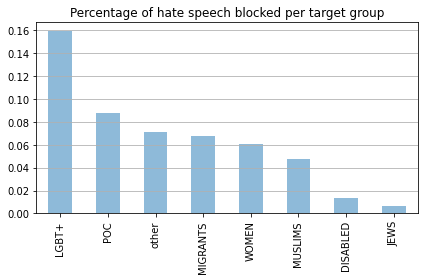

In [ ]:
### Plot percentage of documents blocked per target group
fig, ax = plt.subplots()
(blocked4["TARGET"].value_counts()/df4["TARGET"].value_counts()).sort_values(ascending=False).plot.bar(alpha=0.5, ecolor='black', capsize=10)
ax.yaxis.grid(True)
ax.set_title("Percentage of hate speech blocked per target group")
plt.tight_layout()
plt.savefig("percentagegroupblocked")

In [ ]:
### Load in MLMA dataset, classify documents and counter-narratives based on blocklists
### Also classify based on tweet sentiment

df2 = pd.read_csv("en_dataset_with_stop_words.csv", index_col=0)
annotation_re = re.compile(r"(.+)/(.+)")
df2["blocked_term_in_tweet"] = [blocked_term_in_tweet2(blocklist, tweet) for tweet in df2["tweet"]]
df2["abusive"] = ["abusive" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2["fearful"] = ["fearful" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2["hateful"] = ["hateful" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2["offensive"] = ["offensive" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2["disrespectful"] = ["disrespectful" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2["normal"] = ["normal" in sentiment.split('_') for sentiment in df2["sentiment"]]
df2.head(15)

### Do same thing for french MLMA dataset
dffr = pd.read_csv("fr_dataset.csv", index_col=0)
annotation_re = re.compile(r"(.+)/(.+)")
dffr["blocked_term_in_tweet"] = [blocked_term_in_tweet2(blocklistfr, tweet) for tweet in dffr["tweet"]]
dffr["abusive"] = ["abusive" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr["fearful"] = ["fearful" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr["hateful"] = ["hateful" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr["offensive"] = ["offensive" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr["disrespectful"] = ["disrespectful" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr["normal"] = ["normal" in sentiment.split('_') for sentiment in dffr["sentiment"]]
dffr.head(15)

,tweet,sentiment,directness,annotator_sentiment,target,group,blocked_term_in_tweet,abusive,fearful,hateful,offensive,disrespectful,normal
HITId,,,,,,,,,,,,,
1,rt @user personnage ainsi q tte la clique gauc...,abusive,direct,shock,origin,other,False,True,False,False,False,False,False
2,@user @user @user bah oui t'as raison l'autre ...,offensive,indirect,shock,other,individual,False,False,False,False,True,False,False
3,moi j'ai personne à qui m'adresser pour réclam...,hateful,direct,anger_confusion_sadness_fear_disgust,other,women,False,False,False,True,False,False,False
4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other,False,False,False,False,False,False,True
5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent,False,False,False,False,False,False,True
6,@user @user en algerie les migrants sont expul...,offensive,indirect,indifference,other,immigrants,False,False,False,False,True,False,False
7,@user sjw et féministe twitter un sale combo,normal,indirect,sadness_indifference,other,women,False,False,False,False,False,False,True
8,@user @user tu sais aussi pourquoi est au dess...,normal,indirect,indifference,other,other,False,False,False,False,False,False,True
9,@user @user mytho t'as juste voulu te faire ke...,offensive,indirect,indifference_disgust,other,individual,False,False,False,False,True,False,False


In [ ]:
### Print percentage of tweets blocked
### This dataset contains only hate speech so we can do this on the full dataset
blockedfr = dffr[dffr["blocked_term_in_tweet"] == True]
print(len(blockedfr)/len(dffr))

blockeddf2 = df2[df2["blocked_term_in_tweet"] == True]
print(len(blockeddf2)/len(df2))

0.07249626307922272


0.40003541703559414
offensive: 0.7135900841080124
hateful: 0.24258521469676847


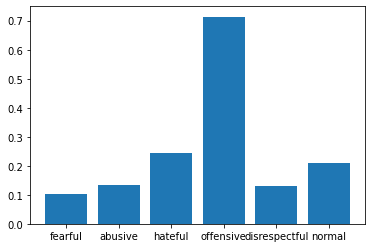

In [ ]:
### Print percentage of tweets blocked per sentiment
### Not used in final paper
blocked2 = df2[df2["blocked_term_in_tweet"] == True]
print(len(blocked2) / len(df2))

count = [len(blocked2[blocked2["fearful"] == True])/len(blocked2), len(blocked2[blocked2["abusive"] == True])/len(blocked2), len(blocked2[blocked2["hateful"] == True])/len(blocked2),
         len(blocked2[blocked2["offensive"] == True])/len(blocked2), len(blocked2[blocked2["disrespectful"] == True])/len(blocked2), len(blocked2[blocked2["normal"] == True])/len(blocked2)]
labels = ["fearful", "abusive", "hateful", "offensive", "disrespectful", "normal"]
plt.bar(labels, count)
print("offensive:", len(blocked2[blocked2["offensive"] == True])/len(blocked2))
print("hateful:", len(blocked2[blocked2["hateful"] == True])/len(blocked2))
#offensive_df2 = df2["offensive" in df2["sentiment"].split('_')]

0.09517239074263568
AxesSubplot(0.125,0.125;0.775x0.755)


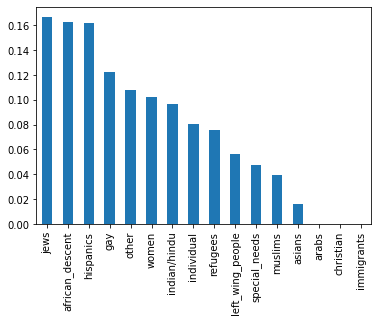

In [ ]:
### Print plot of percentage of tweets blocked per target group
### Not used in final paper
blocked2hateful = blocked2[blocked2["normal"] == True]
hateful2 = df2[df2["normal"] == True]
blockedfrhateful = dffr[dffr["blocked_term_in_tweet"] == True]
blockedfrhateful = blockedfrhateful[blockedfrhateful["normal"] == True]
#print(len(blocked2hateful) / len(hateful2))
#print(hateful2["group"].value_counts())
#print("-------------")
#print(blocked2hateful["group"].value_counts())
print((blocked2hateful["group"].value_counts()/df2["group"].value_counts()).mean())
print((blocked2hateful["group"].value_counts()/df2["group"].value_counts()).sort_values(ascending=False).plot.bar(color='#1f77b4'))
#print((blockedfrhateful["group"].value_counts()/dffr["group"].value_counts()).sort_values(ascending=False).plot.bar(color='#1f77b4'))
plt.savefig("classes.png")

Load tweets into dataframe

In [ ]:
### Unzip Stormfront dataset
!unzip hate-speech-dataset-master.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
 extracting: hate-speech-dataset-master/all_files/30565053_2.txt  
  inflating: hate-speech-dataset-master/all_files/30565413_1.txt  
 extracting: hate-speech-dataset-master/all_files/30565413_2.txt  
  inflating: hate-speech-dataset-master/all_files/30565441_1.txt  
  inflating: hate-speech-dataset-master/all_files/30565949_1.txt  
  inflating: hate-speech-dataset-master/all_files/30565949_2.txt  
  inflating: hate-speech-dataset-master/all_files/30565949_3.txt  
 extracting: hate-speech-dataset-master/all_files/30565999_1.txt  
  inflating: hate-speech-dataset-master/all_files/30565999_2.txt  
 extracting: hate-speech-dataset-master/all_files/30566107_1.txt  
  inflating: hate-speech-dataset-master/all_files/30566107_2.txt  
 extracting: hate-speech-dataset-master/all_files/30566120_1.txt  
  inflating: hate-speech-dataset-master/all_files/30566120_2.txt  
  inflating: hate-speech-dataset-master/all_files/30566120_3.txt  
  inflat

In [ ]:
### Load Stormfront dataset and classify based on blocklist
df3 = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
posts = []
for post in df3["file_id"]:
  with open("hate-speech-dataset-master/all_files/" + post + ".txt") as f:
    posts.append(f.read())
df3["post"] = posts
df3["blocked_term_in_tweet"] = [blocked_term_in_tweet2(blocklist, post) for post in df3["post"]]
df3.head(15)

,file_id,user_id,subforum_id,num_contexts,label,post,blocked_term_in_tweet
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been...",False
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...,False
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...,False
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...,False
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,False
5,12834217_6,572066,1346,0,noHate,"Booklet updated on Feb. 14th , 2014 .",False
6,12834217_7,572066,1346,0,noHate,"( Now with over 18,300 Downloads. )",False
7,12834217_8,572066,1346,0,noHate,PDF file : http://www.mediafire.com/download/7...,False
8,12834217_9,572066,1346,0,noHate,Then why not simply copy this text ( & links )...,False
9,12834217_10,572066,1346,0,noHate,Thank you in advance. : ) Download the youtube...,False


In [ ]:
### Print percentage of hate speech blocked
### Here we do have to account for non-hate speech documents
blocked_df3 = df3[df3["blocked_term_in_tweet"] == True]
blocked_df3_hate = blocked_df3[blocked_df3["label"] == "hate"]

test1 = df3[df3["blocked_term_in_tweet"] == True]
test1 = test1[test1["label"] == "hate"]
test2 = df3[df3["label"] == "hate"]
print(len(test1)/len(test2))

0.08946488294314381


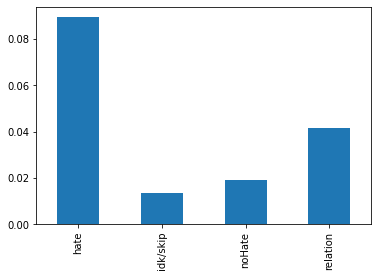

In [ ]:
(blocked_df3['label'].value_counts(sort = False) / df3['label'].value_counts(sort=False)).plot.bar(color='#1f77b4')
plt.savefig("stormfront.png")

In [ ]:
# Check if a blocked term occurs in a tweet for Davidson (2017)
def blocked_term_in_tweet(blocklist, pos_tagged_tweet):
  for blocked in blocklist:
    blocked_split = blocked.split()
    for j in range(len(pos_tagged_tweet)):
      if pos_tagged_tweet[j][0].lower() == blocked_split[0].lower():
        blocked_found = True
        for i in range(len(blocked_split)):
          if j+i >= len(pos_tagged_tweet) or pos_tagged_tweet[j+i][0].lower() != blocked_split[i].lower():
            blocked_found = False
        if blocked_found == True:
          return True 
  return False

In [ ]:
### Sanity check for above function
def test(blocklist, pos_tagged_tweet):
  for blocked in blocklist:
    blocked_split = blocked.split()
    for j in range(len(pos_tagged_tweet)):
      if pos_tagged_tweet[j][0] == blocked_split[0]:
        blocked_found = True
        for i in range(len(blocked_split)):
          if j+i >= len(pos_tagged_tweet) or pos_tagged_tweet[j+i][0] != blocked_split[i]:
            blocked_found = False
        if blocked_found == True:
          return blocked
  return ""

In [ ]:
# Load Davidson dataset and classify based on blocklist
df = pd.read_csv("labeled_data_preprocessed.csv", index_col = 0)
annotation_re = re.compile(r"(.+)/(.+)")
df['pos_tagged_tweet'] = df['pos_tagged_tweet'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df['lemmatized_tweet'] = df['lemmatized_tweet'].apply(lambda x: [annotation_re.findall(s)[0] for s in x.split()])
df["blocked term in tweet"] = [blocked_term_in_tweet(blocklist, tweet) for tweet in df["pos_tagged_tweet"]]
#df["blocked"] = [test(blocklist, tweet) for tweet in df["pos_tagged_tweet"]]
df.head(15)  # the first 25 tweets, along with their annotation

,count,hate_speech,offensive_language,neither,class,raw_tweet,pos_tagged_tweet,lemmatized_tweet,blocked term in tweet
id,,,,,,,,,
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher...",False
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher...",False
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher...",True
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher...",True
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[(!, .), (!, .), (!, .), (rt, NOUN), (mentionh...","[(!, !), (!, !), (!, !), (rt, rt), (mentionher...",True
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...","[(!, .), (!, .), (!, .), (mentionhere, NOUN), ...","[(!, !), (!, !), (!, !), (mentionhere, mention...",True
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...","[(!, .), (!, .), (!, .), (mentionhere, NOUN), ...","[(!, !), (!, !), (!, !), (mentionhere, mention...",True
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,"[(!, .), (!, .), (!, .), (mentionhere, ADV), (...","[(!, !), (!, !), (!, !), (mentionhere, mention...",True
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...","[(&, CONJ), (you, PRON), (might, VERB), (not, ...","[(&, &), (you, you), (might, might), (not, not...",True


Distribution of judgements

0     1430
1    19140
2     4159
Name: class, dtype: int64

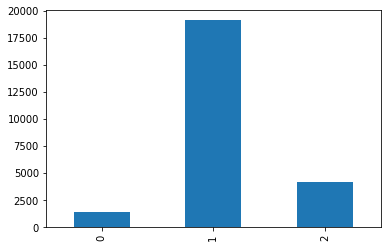

In [ ]:
df['class'].value_counts(sort = False).plot.bar(color='#1f77b4')
df['class'].value_counts(sort = False)

Divide based on blocklist

In [ ]:
blocked_df = df[df["blocked term in tweet"] == True]
#notblocked_df = df[df["blocked term in tweet"] == False]

In [ ]:
print(len(blocked_df[blocked_df["class"] == 0]) / len(df[df["class"] == 0]))

0.6286713286713287


Print amount blocked per class, normalized by the amount of datapoints in that class

0    0.628671
1    0.767712
2    0.035105
Name: class, dtype: float64


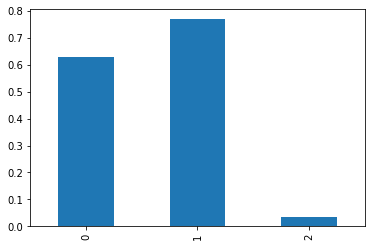

In [ ]:
(blocked_df['class'].value_counts(sort = False) / df['class'].value_counts(sort=False)).plot.bar(color='#1f77b4')
print((blocked_df['class'].value_counts(sort = False) / df['class'].value_counts(sort=False)))
plt.savefig('blocked.png')

In [ ]:
print(blocked_df.loc[684,:]['raw_tweet'])

#BigBird was made by a gay couple. So yes, under a GOP world the bird would not have existed since its creators would be in jail for sodomy.


In [ ]:
### Print harmless tweets that were blocked
temp = blocked_df[blocked_df["class"] == 2]
print(len(temp))
for tweet in temp.raw_tweet:
  print(tweet)

146
" momma said no pussy cats inside my doghouse "
"@EdgarPixar: Overdosing on heavy drugs doesn't sound bad tonight." I do that pussy shit every day.
"@MaxMayo77: http://t.co/XpSC3makgJ" sexy lad with hot soles and arches.
"@SportsCenter: USC senior RB Anthony Brown calls head coach Steve Sarkisian a racist and quits team. &#187; http://t.co/JOOsdSubIR" he's a bitch
"@Stephenwildboy: Chilling &#128069;&#8482; http://t.co/mik3iPNle6" sexy scally lad
"@soxdawg: RAWR!! RT @skinrubberboi: "My" sexy French scally. I love him! #frenchscally http://t.co/5idQ3R5Akz" sexy scally woof woof
"when rappers say twat it makes me feel weird" &#128514;&#128514;&#128514;&#128557;
#BigBird was made by a gay couple. So yes, under a GOP world the bird would not have existed since its creators would be in jail for sodomy.
&#8220;@A_Brown_30: Frogger, best game ever&#8221; only cuz You suck at flappy bird
&#8220;@BestOfAds: Rape? Cannibalism? You Won't Recognize The Original Versions Of These Fairy Tales h